# Twitter US Airlines Sentiment with ULMFiT

## Introduction

This notebook implements training the [AWD-LSTM](https://arxiv.org/pdf/1708.02182.pdf) architecure according to [ULMFiT](https://arxiv.org/pdf/1801.06146.pdf) paper on the [Twitter US Airline Sentiment Dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment) using fastai library. The aim of the model is to determine sentiments of the tweets.

First, needed libraries are imported.

In [272]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn

from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline 

We read the file containing tweets into a DataFrame object and have a look at the first few records.

In [273]:
df = pd.read_csv('../input/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We see that our DataFrame contains numerous columns that provide information about the corresponding tweet. In our context of training a language model the most important columns are 'airline_sentiment' and 'text'. Let's check if there're no missing values in them.
Next we visualise the counts of tweets by sentiment category.

In [274]:
df[['airline_sentiment', 'text']].isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

There're no missing values so we can proceed. Let's visualise counts of tweets by sentiment category.

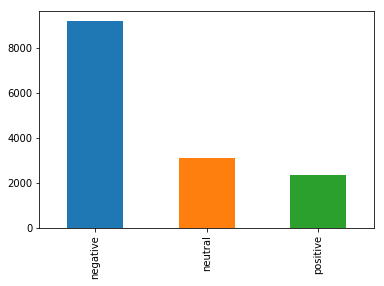

In [275]:
df['airline_sentiment'].value_counts().plot(kind='bar')

We see that neutral and positive tweets are underepresented compared to negative ones. We will not balance this dataset and evaluate the perfomance of the model on the test set with the same proportion of sentiments.

Next let's investugate the relationship between tweet length and its sentiment.

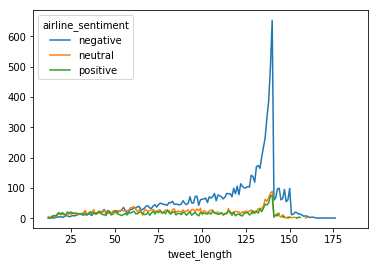

In [276]:
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line')

We see that for negative sentiment distribution is higly skewed towards longer tweets. 

We split our dataset into train and test parts. We don't show the test part to our model until it is trained and use it for evaluation purposes. Then we save them as .csv files for later purporses.

In [277]:
rnd_state = 111
df_train, df_test = train_test_split(df, test_size=0.15, random_state = rnd_state)
df_train[['airline_sentiment', 'text']].to_csv('Tweets_train.csv', index=False, encoding='utf-8')
df_test[['airline_sentiment', 'text']].to_csv('Tweets_test.csv', index=False, encoding='utf-8')



Now we create TextDataBunch objects for language model and classifier and save them so in future iterations we can load them straight away and skip running previous steps. 

We specify 15% our training data for validation purposes so that we can experiment with hypoparameters and adjust them based on perfomance on the validation data.

In [278]:
data_lm = TextLMDataBunch.from_csv('.', 'Tweets_train.csv', valid_pct=0.15)
data_clas = TextClasDataBunch.from_csv('.', 'Tweets_train.csv', valid_pct=0.15, vocab=data_lm.train_ds.vocab, bs=32)
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

Load previosly created data for language model and classifier.

In [279]:
data_lm = load_data('.', 'data_lm_export.pkl')
data_clas = load_data('.', 'data_clas_export.pkl', bs=32)

Now we have a look at what our TextDataBunch objects contain. The texts of tweets has gone through automatic tokenization stage that includes but not limited to:
* Separation according to spaces and punctuation.
* Transforming text to lower case.
* Introducing special tokens that encode spicific information, e.g. indication of the beginning of a text.
After that tokens are numericalised meaning substituting words by their values in the vocabulary. The resulting numerical sequences will serve as inputs for the language model.
We print an example preprocessed text with the encoding it was transformed to.

In [280]:
print("Preprocessed text:", data_lm.x[0])
print("\n")
print("Corresponding numerical sequence:", data_lm.x[0].data)


Preprocessed text: xxbos @united xxmaj what does " xxmaj cabin xxmaj functionality " mean when i 'm taking a customer satisfaction survey ?


Corresponding numerical sequence: [   2   21    5   71  133   65    5  859    5 3858   65  545   86   11   80  450   15   73 3859 2601   14]


## 1. Language model

Now we implement our language model. The UlMFit apporach consists of three main steps:
1. Pretraining the language model. We will download the model pretrained on a large corpus of English text. 
2. Fine-tuning the language model. This is necessary to adjust the language model to the specificities of the dataset we are going to work with.
3. Using our language model as an ecoder for the classifier which will infer the sentiment of the tweets.

Now we are ready to create the learner for our model. It will come with pretrained [AWD_LSTM](https://arxiv.org/pdf/1708.02182.pdf) architecure which will serve as our laguage model. 

In [281]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)


Next we explore the space of possible learning rates.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


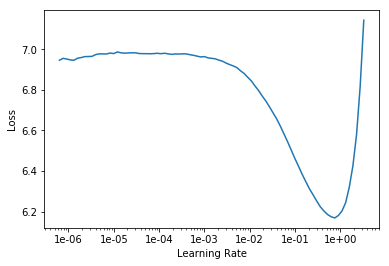

In [282]:
learn.lr_find()
learn.recorder.plot()

Next we fit the last layer of our model for 1 epoch using 1 cycle policy. This approach was described to work best in the original paper. We use the learning rate of one order of magnitude lower than the one corresponding to the lowest loss on the previous plot as recommended. We use values for the cyclic momentum and other parameters as they were found to work well in guidelines of fastai course.

In [283]:
learn.fit_one_cycle(1, 1e-02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.306254,4.332844,0.221632,00:06


Next we unfreeze the whole model and fine-tune it for 10 epochs.

In [284]:
learn.unfreeze()
learn.fit_one_cycle(10,1e-03, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.429353,4.095856,0.249817,00:08
1,4.241044,3.932308,0.271489,00:07
2,4.079092,3.818842,0.280093,00:08
3,3.922644,3.750963,0.288332,00:07
4,3.779513,3.705878,0.294257,00:07
5,3.654723,3.679228,0.296429,00:07
6,3.550940,3.666553,0.296956,00:07
7,3.471123,3.665824,0.297463,00:07
8,3.415020,3.664080,0.297200,00:07
9,3.381201,3.664337,0.297220,00:08


In the last few epochs we see that the accuracy on the validation set stagnates which means that training further will only lead to overfitting.

Next we ask our trained language model to finish a phrase.

In [285]:
learn.predict("My experience was", n_words=10)

'My experience was ok with Cancelled Flightled flight and a few'

We see that our model follows basic rules of grammar. 

Finally we save our trained model to use it as an encoder for the classifier.

In [286]:
learn.save_encoder('ft_enc')

## 2. Classifier

Now it's time to implement the final stage of ULMFit - Classifier. Fot this we create an appropriate learner and import our fine-tuned language model as an encoder.

In [287]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

Again, let's explore different values for the learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


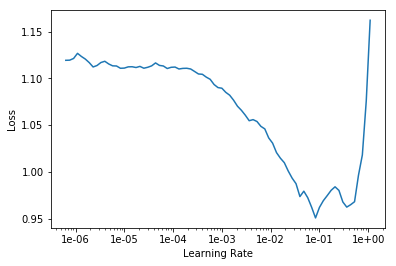

In [288]:
learn.lr_find()
learn.recorder.plot()

Now we will train our classifier gradually unfreezing layers from the top. Training all layers straight way may result in loss of information achieved through fine-tuning of language model. 

In [290]:
learn.fit_one_cycle(8, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.682942,0.537429,0.786824,00:06
1,0.655243,0.532780,0.772898,00:06
2,0.646463,0.528764,0.795394,00:06
3,0.619592,0.503237,0.797001,00:06
4,0.611944,0.511356,0.795394,00:06
5,0.570965,0.483966,0.803964,00:06
6,0.574974,0.482108,0.808249,00:06
7,0.567295,0.481574,0.806642,00:06


In [291]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.599458,0.501742,0.798072,00:07
1,0.578998,0.488006,0.807177,00:06
2,0.533419,0.465607,0.820568,00:07
3,0.514364,0.455950,0.827531,00:07
4,0.457032,0.459975,0.823781,00:07


In [292]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.440196,0.475264,0.825388,00:13
1,0.426092,0.453305,0.831280,00:14
2,0.380461,0.461150,0.833958,00:13
3,0.330918,0.486886,0.830745,00:13
4,0.263258,0.495219,0.831280,00:14


## Evaluating the model

Now we will evalute the perfomance. For this let's first read the previously saved test part of our dataset. Then make a prediction of each tweet.

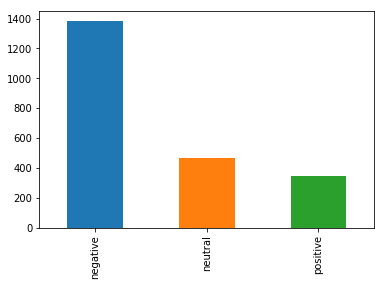

In [293]:
test_df = pd.read_csv("Tweets_test.csv", encoding="utf-8")
test_df['pred_sentiment'] = test_df['text'].apply(lambda row: str(learn.predict(row)[0]))
test_df['airline_sentiment'].value_counts().plot(kind='bar')

We see that test set contains same proportion of sentiments as train set.
Finally we calculate the accuracy on the test set. 

In [294]:
print("Test Accuracy: ", accuracy_score(test_df['airline_sentiment'], test_df['pred_sentiment']))

Test Accuracy:  0.8324225865209471


Now let's ivestigate mistakes that has been made by our model using confusion matrix.

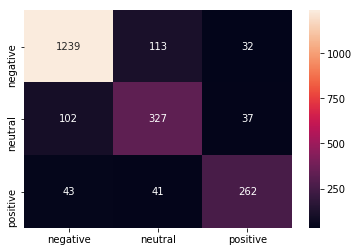

In [295]:
conf_matrix = confusion_matrix(y_true=test_df['airline_sentiment'].values, y_pred=test_df['pred_sentiment'].values, labels=['negative', 'neutral', 'positive'])
labels = ['negative', 'neutral', 'positive']
sn.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)

We see that our model classified significant amount of neutral tweets as negatives which is reasonable because even as humans it sometimes not clear. What is more interesting is to look at positive tweets that were classified as negatives.

In [296]:
pd.set_option('display.max_colwidth', -1)
test_df.loc[(test_df['airline_sentiment'] == 'positive') & (test_df['pred_sentiment'] == 'negative')].head()

,airline_sentiment,text,pred_sentiment
54,positive,@united good job at CLE .. TPA on schedule ... 4 to 5 inches of snow ! http://t.co/9tbsJquw41,negative
63,positive,@AmericanAir yes called your UK number on skype…well worth the $.50. i recommend others do the same.,negative
128,positive,@united you suck. @SouthwestAir you're the best.,negative
129,positive,"@USAirways your ticket agents at gate 4 in Providence airport rocked tonight, especially Kristy, sorry if that is not the correct spelling.",negative
152,positive,"@united This is probably the least dependable airline in the Western Hemisphere. @united does not belong in Star Alliance, but SkyTeam",negative


From here we see that these tweets are indeed confusing as often they are responses to other users' tweets.

## Coclusion
In this notebook we explored the application of ULMFiT strategy for detecting sentiments of tweets and achieved level of accuracy similar to human. Improvement in perfomance might be obtained by tweaking the parameters of the model as well as taking into account additional information such as relation between particular tweets.